#  How to create a Hand Wash Detection And Timer Application using MXNet / PanoramaSDK

**Goal of this Notebook** :

* Aid an Panorama developer prototype their application before creating the AWS Lambda for Panorama
* Creating an MXNET application in the same structure as the AWS Lambda for Panorama
* Create and Deploy the AWS Lambda for Panorama from this notebook

**What this Notebook accomplishes?** :
* Detect Handwashing using Kinetics 400 Model using MXNet
* Time the Handwashing and display the Handwashing time on screen
* Show the structure of the AWS Lambda for Panorama and replicate it using MXNet
* Create and publish the included AWS Lambda for Panorama directly to the AWS Lambda service


**Useful Resources to aid your development**:
* [AWS Panorama Documentation](https://docs.aws.amazon.com/panorama/)


**Pre -Requisites**:
* Sagemaker Instance created with the right role (Policies needed IOT, Lambda and S3, IAM Full Access to your sagemaker role)


**Frames to Process**:

* By default, we only process 10 frames from the video. If you want to increase this, please change this value in /panorama_sdk/panoramasdk.py and change frames_to_process = 10 to a value of your choice

#### Video to Use

In [1]:
video_to_use = "washing_hands.mp4"

#### Step 1: Import Libraries

In [2]:
!pip3 install -r requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.


#### Import the required roles

In [3]:
import sagemaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

#### Imports

In [4]:
import imutils
import json
import os
from IPython.display import clear_output, Markdown, display

import mxnet as mx
from mxnet import gluon, nd, image
from mxnet.gluon.data.vision import transforms
from gluoncv.data.transforms import video
from gluoncv import utils
from gluoncv.model_zoo import get_model

import time
import cv2
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)


In [5]:
def printmd(string, color=None):
    """
    Helper Function for Fomatting Output
    """
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

#### Step 2: Modelling Approach

This step walks through using the MXNet model to get inference

* **Model** : resnet101_v1b_kinetics400  
* **Kinetics400** : These models are trained on [Kinetics400](https://deepmind.com/research/open-source/kinetics), a large-scale, high-quality dataset of URL links to approximately 650,000 video clips that covers 400 human action classes, including human-object interactions such as playing instruments, as well as human-human interactions such as shaking hands and hugging.   
* **arXiv** :[The Kinetics Human Action Video Dataset](https://arxiv.org/abs/1705.06950)  
* **Model Input Size** : 224 x 224  
* **Model Output** : 400 Classes



##### **A. Loading the model**

In [6]:
action_detection_model_name = 'resnet101_v1b_kinetics400'
action_detection_model = get_model(action_detection_model_name, nclass=400, pretrained=True)

##### **B. Loading the input video**


In [7]:
inputs = '../panorama_sdk/Sources/washing_hands.mp4'

##### **C. Preprocessing function**


In [8]:
def preprocess(img, size):

    """
    # Performing transformations for the video clip / camera feed. This transformation function
    # does three things: center crop the image to 224x224 in size,
    # transpose it and normalize with
    # mean and standard deviation calculated across all frames.

    """
    resized = cv2.resize(img, (size, size))

    mean = [0.485, 0.456, 0.406]  # RGB
    std = [0.229, 0.224, 0.225]  # RGB

    # converting array of ints to floats
    img = resized.astype(np.float32) / 255.0
    img_a = img[:, :, 0]
    img_b = img[:, :, 1]
    img_c = img[:, :, 2]

    # Extracting single channels from 3 channel image
    # normalizing per channel data:
    img_a = (img_a - mean[0]) / std[0]
    img_b = (img_b - mean[1]) / std[1]
    img_c = (img_c - mean[2]) / std[2]

    # putting the 3 channels back together:
    x1 = [[[], [], []]]
    x1[0][0] = img_a
    x1[0][1] = img_b
    x1[0][2] = img_c

    x1 = np.asarray(x1)
    return x1

##### **D. Using the model to do inference**

The below example code does inference only on the first 150 frames. The code also visualizes the top 3 actions detected at each frame
  
**Note :** The actual / meaningful predictions start at around Frame 120

In [9]:
# Loading the video using opencv

cap = cv2.VideoCapture(inputs)
frame_number = 0
inference_on_number_of_frames = 10

# Looping thru the video
while(cap.isOpened()):
    
    # Increment Frame Number
    frame_number += 1
    
    (grabbed, frame) = cap.read()

    # Preprocess Frame. We resize to 224 x 224
    prep_frame = preprocess(frame, 224)

    # Predict
    pred = action_detection_model(nd.array(prep_frame))
    
    # Get Classes
    classes = action_detection_model.classes
    
    # If you want to look at the classes, uncomment the next print statement. 
    # Warning: really large list will be printed. 
    
    # Get Top n classes predicted
    topK = 3
    ind = nd.topk(pred, k=topK)[0].astype('int')
    topKlist = []

    # Collect the top n Classes Predicted and print on screen
    for i in range(topK):
        a = 25 + 25 * i
        class_pred = classes[ind[i].asscalar()]
        cv2.putText(frame, 'Action {}: {}'.format(i + 1,class_pred), (10, a), cv2.FONT_HERSHEY_SIMPLEX,0.8, (255, 255, 255), 2)
    
    cv2.putText(frame, 'frame : {}'.format(frame_number), (10, a + 25), cv2.FONT_HERSHEY_SIMPLEX,0.8, (255, 255, 255), 2)
    
    # Convert to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Output the frame
    plt.imshow(frame)
    plt.show()
    
    # Clear output
    clear_output(wait = True)

    # observe the keypress by the user
    keypress = cv2.waitKey(1) & 0xFF

    # if the user pressed "q", then stop looping
    if keypress == ord("q") or frame_number == inference_on_number_of_frames:
        break

# free up memory
cap.release()
cv2.destroyAllWindows()  

#### Step 3 : Understanding and creating the Structure of the Application

* A, B, C and D within Step 2 showed how to use the Action Recognition model to do inference. 

* This step will introduce the structure of the Panorama Lambda. 

* This step also walks through the code to understand how the Lambda structure can be created. 

**Note**: 

* The code structure below is as close to the lambda structure as possible, but is **NOT** the actual Lambda.

* To see and compare the actual lambda to this code, please open the HandWashDetection.py file in the Lambda folder. 

The Panorama Lambda function has the following structure

**Note** : Actual Lambda inherits base class called panoramasdk.base instead of object

In [10]:
### Lambda skeleton


class HandWashDetection(object):
    def interface(self):
        # defines the parameters that interface with other services from Panorama
        return

    def init(self, parameters, inputs, outputs):
        # defines the attributes such as arrays and model objects that will be used in the application
        return

    def entry(self, inputs, outputs):
        # defines the application logic responsible for predicting using the inputs and handles what to do
        # with the outputs
        return

Using the above structure to create a class that resembles the Panorama lambda as much as possible

In [11]:
import os
import sys
path = os.path.abspath(os.path.join(os.path.dirname("panorama_sdk"), '../..'))
sys.path.insert(1, path + '/panorama_sdk')
import jupyter_utils

jupyter_utils.change_video_source(video_to_use)

Video Changed to washing_hands.mp4


In [12]:
import panoramasdk
import cv2
import numpy as np
import time
import boto3
from classes import load_classes
import json

# [AWS Panorama Documentation](https://docs.aws.amazon.com/panorama/)


s3 = boto3.resource('s3')
iot = boto3.client('iot-data', region_name='us-east-1')

class HandWashDetection(panoramasdk.base):
    
    def interface(self):
        return {
            "parameters":
            (
                ("model", "action_detection", "Model for detecting_action", "resnet101_v1b_kinetics400"),
            ),
            "inputs":
            (
                ("media[]", "video_in", "Camera input stream"),
            ),
            "outputs":
            (
                ("media[video_in]", "video_out", "Camera output stream"),
            )
            
        }
        
    def init(self, parameters, inputs, outputs):
        
        try:
            # Frame Number
            self.frame_num = 0

            # Load model from the specified directory
            print("loading model")
            self.action_detection_model = panoramasdk.model()
            self.action_detection_model.open(parameters.action_detection, 1)
            print("model loaded")

            # Panorama SDK specific declarations
            self.class_name_list = []
            self.class_prob_list = []
            class_info = self.action_detection_model.get_output(0)
            self.class_array = np.empty(class_info.get_dims(), dtype=class_info.get_type())
                        
            # Set up Timer
            self.time_start = time.time()
            self.seconds_to_wash = 120
            
            # Misc
            self.list_actions = []
            self.message = ''

            return True

        except Exception as e:
            print("Exception: {}".format(e))
            return False
    
    def preprocess(self, img, size):
        
        resized = cv2.resize(img, (size, size))
        mean = [0.485, 0.456, 0.406]  # RGB
        std = [0.229, 0.224, 0.225]  # RGB
        
        img = resized.astype(np.float32) / 255.  # converting array of ints to floats
        img_a = img[:, :, 0]
        img_b = img[:, :, 1]
        img_c = img[:, :, 2]
        
        # Extracting single channels from 3 channel image
        # The above code could also be replaced with cv2.split(img) << which will return 3 numpy arrays (using opencv)
        # normalizing per channel data:
        img_a = (img_a - mean[0]) / std[0]
        img_b = (img_b - mean[1]) / std[1]
        img_c = (img_c - mean[2]) / std[2]
        
        # putting the 3 channels back together:
        x1 = [[[], [], []]]
        x1[0][0] = img_a
        x1[0][1] = img_b
        x1[0][2] = img_c
        x1 = np.asarray(x1)
        
        return x1
    
    
    def entry(self, inputs, outputs):
        
        for i in range(len(inputs.video_in)):
            stream = inputs.video_in[i]
            
            self.frame_num += 1
            
            image_input = stream.image
            
            # Pre Process Frame
            prep_frame = self.preprocess(image_input, 224)

            # Predict
            self.action_detection_model.batch(0, prep_frame)
            self.action_detection_model.flush()

            # Get the results.
            resultBatchSet = self.action_detection_model.get_result()
                        
            class_batch = resultBatchSet.get(0)
            class_batch.get(0, self.class_array)
            class_data = self.class_array[0]
            
            # Load Classes
            classes = load_classes()
            
            # declare topKlist
            topKlist = []
            
            # Collect the Top 10 Classes
            sorted_vals = sorted(((value,index) for index, value in enumerate(class_data)), reverse=True)
            ind = [d for (c,d) in sorted_vals][0:10]
            for z in range(len(ind)):
                class_name = classes[ind[z]]
                topKlist.append(class_name)
                
                                    
            # Here we want to be certain that we are detecting washing hands
            if 'washing_hands' in topKlist:
                self.list_actions.append(1)
            else:
                self.list_actions.append(0)
            
            if len(self.list_actions) > 20:
                self.list_actions = self.list_actions[-20:]
                    
            # Once we definitively detect washing hands, we start writing to the frame
            if ('washing_hands' in topKlist and sum(self.list_actions) > 10):
                hours, rem = divmod(time.time() - self.time_start, 3600)
                minutes, seconds = divmod(rem, 60)
                count_seconds = self.seconds_to_wash - int(minutes*60 + seconds)
                
                # write on frame 
                #cv2.putText(image_input, 'Action: Washing Hands', (100, 25), cv2.FONT_HERSHEY_SIMPLEX , 0.5, (255, 0, 0) , 2, cv2.LINE_AA)
                stream.add_label('Action: Washing Hands',0.1,0.25)
                
                if count_seconds <= 0:
                    stream.add_label('Time : {}'.format(0),0.1,0.5)
                    stream.add_label('Message : {}'.format('Great Job'),0.1,0.75)
                    self.message = 'Great Job'
                    
                # Reset Time start after 10 seconds. Until then show message
                if count_seconds <= -10:
                    stream.add_label('Time : {}'.format(0),0.1,0.5)
                    self.time_start = time.time()
                    self.message = ''
                else:
                    
                    stream.add_label('Time : {}'.format(count_seconds),0.1,0.5)
                    self.message = ''
            
            # Top k action list to MQTT message
            response = iot.publish(topic='HandWashing',qos=1,payload=json.dumps({"results":topKlist,"message":self.message}))
        
            self.action_detection_model.release_result(resultBatchSet)
            outputs.video_out[i] = stream
        

        return True
            
            
        
            

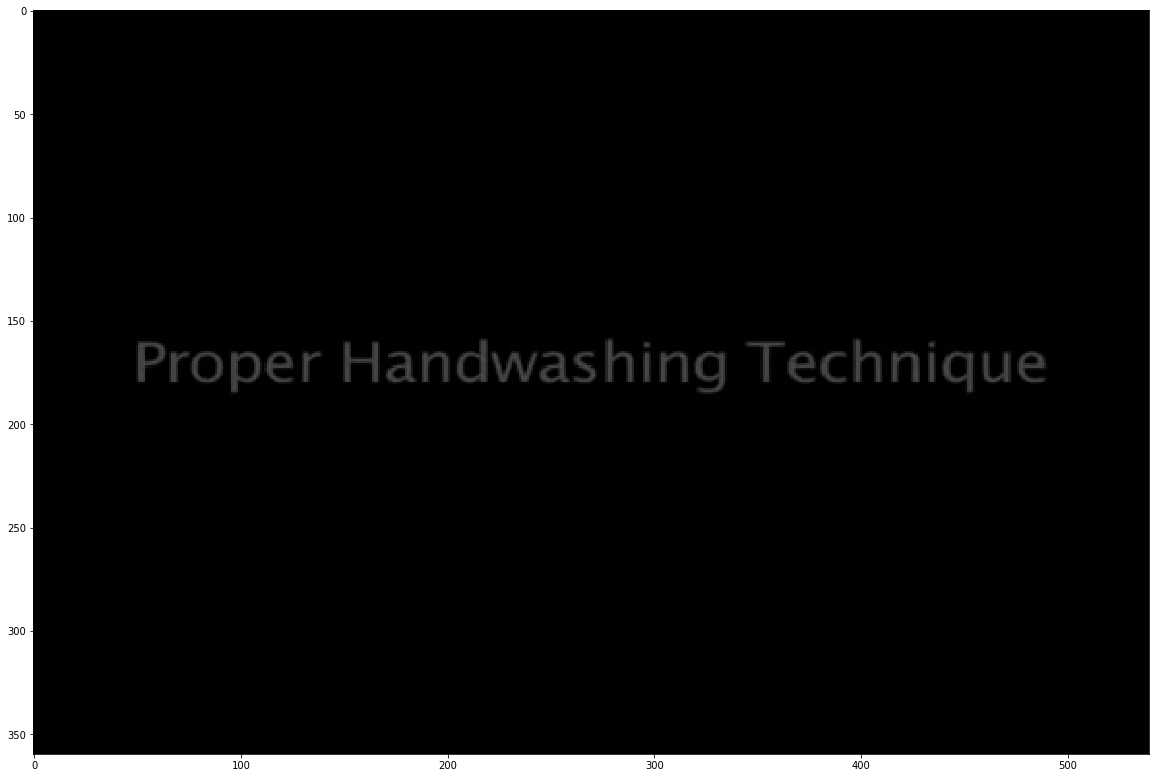

In [13]:
def main():
    HandWashDetection().run()
main()

#### Step 4 : Upload Lambda and Create Lambda Function

* A lambda is already provided and ready for use in the lambda folder (zip file)
* Use this code snippet to upload and publish it to Lambda Service


This Python snippet uses boto3 to create an IAM role named LambdaBasicExecution with basic 
lambda execution permissions.

In [27]:
role_policy_document = {
    "Version": "2012-10-17",
    "Statement":[
        {
            "Effect": "Allow",
            "Principal": {"Service": ["lambda.amazonaws.com", "events.amazonaws.com"]},
            "Action": "sts:AssumeRole",
        }
    ]
}

iam_client = boto3.client("iam")

iam_client.create_role(
    RoleName="HandWashingExecutionRole",
    AssumeRolePolicyDocument=json.dumps(role_policy_document),
)

{'Role': {'Path': '/',
  'RoleName': 'HandWashingExecutionRole',
  'RoleId': 'AROAZAPJMVFPFVXCRLC7I',
  'Arn': 'arn:aws:iam::619501627742:role/HandWashingExecutionRole',
  'CreateDate': datetime.datetime(2020, 11, 6, 22, 0, 48, tzinfo=tzlocal()),
  'AssumeRolePolicyDocument': {'Version': '2012-10-17',
   'Statement': [{'Effect': 'Allow',
     'Principal': {'Service': 'lambda.amazonaws.com'},
     'Action': ['sts:AssumeRole']},
    {'Effect': 'Allow',
     'Principal': {'Service': 'events.amazonaws.com'},
     'Action': ['sts:AssumeRole']}]}},
 'ResponseMetadata': {'RequestId': 'e30aeb74-2c74-443b-90c8-db7e0b7b8d9b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'e30aeb74-2c74-443b-90c8-db7e0b7b8d9b',
   'content-type': 'text/xml',
   'content-length': '979',
   'date': 'Fri, 06 Nov 2020 22:00:47 GMT'},
  'RetryAttempts': 0}}

The following Python snippet will use the resources above to create a new AWS Lambda function called HandWashingLambda

In [14]:
!zip -o  ../Lambda/HandWashingLambda.zip  ../Lambda/classes.py ../Lambda/HandWashDetection.py

  adding: ../Lambda/classes.py (deflated 63%)
  adding: ../Lambda/HandWashDetection.py (deflated 68%)


In [32]:
lambda_client = boto3.client("lambda")

with open(
    "../Lambda/HandWashingLambda.zip", "rb"
) as f:
    zipped_code = f.read()

role = iam_client.get_role(RoleName="HandWashingExecutionRole")
response_create_function = lambda_client.create_function(
    FunctionName="HandWashingDetectionLambda",
    Runtime="python3.7",
    Role=role["Role"]["Arn"],
    Handler="HandWashDetection.main",
    Code=dict(ZipFile=zipped_code),
    Timeout=120,
    MemorySize=2048,
)

**What is an ARN?** : Amazon Resource Names (ARNs) uniquely identify AWS resources.

The following Python snippet will publish the Lambda Function we created above, and return an ARN with a version. 

This version arn can be used to go directly to the Panorama console and deploy this application.

In [33]:
response = lambda_client.publish_version(FunctionName="HandWashingDetectionLambda")

Printing the details of the lambda function that was just published

In [34]:
function_arn = response["FunctionArn"]
function_arn_version = list(response["FunctionArn"].split(":"))[-1]
lambda_url = (
    "https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/"
    + response["FunctionName"]
    + "/versions/"
    + response["Version"]
    + "?tab=configuration"
)

printmd("**Function Arn** : **{}**".format(function_arn), color="black")
printmd("**Function Arn Version** : **{}**".format(function_arn_version), color="black")
printmd("**Lambda Console Link** : **{}**".format(lambda_url), color="black")

<span style='color:black'>**Function Arn** : **arn:aws:lambda:us-east-1:619501627742:function:HandWashingDetectionLambda:1**</span>

<span style='color:black'>**Function Arn Version** : **1**</span>

<span style='color:black'>**Lambda Console Link** : **https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/HandWashingDetectionLambda/versions/1?tab=configuration**</span>

#### Step 4 : Upload Model to S3 Bucket

In [35]:
def send_model_to_s3(model, bucket = 'aws-panorama-models-bucket'):
    s3 = boto3.resource('s3')
    s3.create_bucket(Bucket=bucket)
    
    key = '../../Models/' + model
    
    s3.Object(bucket, model).put(Body=open(key, 'rb'))
    
    bucket_name = bucket
    
    
    location = boto3.client('s3').get_bucket_location(Bucket='aws-panorama-models-bucket')['LocationConstraint']
    url = "s3://{}/{}".format(bucket_name, key)
    
    printmd("**S3 Path** : **{}**".format(url), color="black")
    
    return

In [36]:
send_model_to_s3(model = 'resnet101_v1b_kinetics400.tar.gz')

<span style='color:black'>**S3 Path** : **s3://aws-panorama-models-bucket/../Models/resnet101_v1b_kinetics400.tar.gz**</span>

#### Step 5 : Deploy the Application

The Lambda is now created and published. You are now ready to deploy your model and the published lambda function, to the Manhattan Panorama device

The instructions to deploy are linked below

[Creating Application Instructions Here](https://docs.aws.amazon.com/panorama/)